In [2]:
!uv pip install langchain

Audited 1 package in 22ms


In [3]:
!uv pip install --upgrade langchain langchain-core langchain-openai langchain-community langchain-chroma langgraph

Resolved 121 packages in 174ms                                       
Audited 121 packages in 1ms


In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [5]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    question: str
    answer: str
    context: List[Document]

In [6]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [7]:
def retrive(state: AgentState) -> AgentState:
    question = state["question"]
    docs = retriver.invoke(question)
    return {"context": docs}

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [9]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")

In [10]:
def generate(state: AgentState) -> AgentState:
    content = state["context"]
    question = state["question"]
    rag_chain = generate_prompt | llm
    answer = rag_chain.invoke({"context": content, "question": question})
    return {"answer": answer}

In [ ]:
from langchain_classic import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def relevance_doc(state: AgentState) -> Literal['generate', 'rewrite']:
    question = state["question"]
    context = state["context"]
    doc_relevance_chain = doc_relevance_prompt | llm
    relevance = doc_relevance_chain.invoke({"question": question, "documents": context})
    print(f"context: {context}")
    print(f"relevance: {relevance}")
    if relevance['Score'] == 1:
        return 'generate'
    
    return 'rewrite'


In [12]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{question}}
""")

def rewrite(state: AgentState):
    question = state["question"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    rewritten_question = rewrite_chain.invoke({"question": question})
    return {"question": rewritten_question}

In [13]:
graph_builder.add_node("retrive", retrive)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrive")
graph_builder.add_conditional_edges("retrive", relevance_doc)
graph_builder.add_edge("rewrite", "retrive")
graph_builder.add_edge("generate", END)

In [15]:
graph = graph_builder.compile()

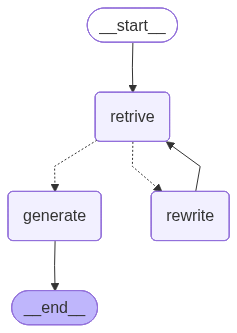

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
inital_state = { 'question': '연봉 5천만원 세금' }
graph.invoke(inital_state)

relevance: {'Score': 1, 'Explanation': 'The question asks about taxes on an annual salary of 50 million won (연봉 5천만원 세금). The provided facts relate to various income tax regulations in South Korea, including virtual asset income tax, real estate transaction income, and retirement income deductions. Although the details are not directly answering the specific question about the tax on a 50 million won salary, they contain relevant keywords and concepts related to income tax calculation, taxable income thresholds, and deductions, which are relevant to the context of tax calculations. Therefore, the provided facts are semantically related to the question, earning a score of 1.'}


{'question': '연봉 5천만원 세금',
 'answer': AIMessage(content="I don't know.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 1507, 'total_tokens': 1511, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159664a9b7', 'id': 'chatcmpl-CT9paouTcqLwZsFuY6gvsCcATYAOn', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--f7645beb-03bc-4ef3-84d3-99dc191e9254-0', usage_metadata={'input_tokens': 1507, 'output_tokens': 4, 'total_tokens': 1511, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'context': [Document(id='fbd8c829-5f7e-49dc-8e40-a4ccca74bf15', metadata={'source': './documents/income_tax.txt'}, 